In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import cv2

In [2]:
import random 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [3]:
import os
for dirName,_,fileNames in os.walk('Images/'):
    for files in fileNames:
        print(os.path.join(dirName,files))

Images/Training\female\131422.jpg.jpg
Images/Training\female\131423.jpg.jpg
Images/Training\female\131425.jpg.jpg
Images/Training\female\131427.jpg.jpg
Images/Training\female\131428.jpg.jpg
Images/Training\female\131429.jpg.jpg
Images/Training\female\131432.jpg.jpg
Images/Training\female\131433.jpg.jpg
Images/Training\female\131435.jpg.jpg
Images/Training\female\131437.jpg.jpg
Images/Training\female\131440.jpg.jpg
Images/Training\female\131449.jpg.jpg
Images/Training\female\131452.jpg.jpg
Images/Training\female\131458.jpg.jpg
Images/Training\female\131459.jpg.jpg
Images/Training\female\131468.jpg.jpg
Images/Training\female\131469.jpg.jpg
Images/Training\female\131472.jpg.jpg
Images/Training\female\131475.jpg.jpg
Images/Training\female\131482.jpg.jpg
Images/Training\female\131484.jpg.jpg
Images/Training\female\131485.jpg.jpg
Images/Training\female\131486.jpg.jpg
Images/Training\female\131489.jpg.jpg
Images/Training\female\131490.jpg.jpg
Images/Training\female\131506.jpg.jpg
Images/Train

In [4]:
traindir='Images/Training/'
validdir='Images/Validation/'
os.listdir(traindir)

['female', 'male']

In [5]:
def show_image(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
        plt.subplots_adjust(hspace=0.2)
        x =dir.split("/")[-1]
        if x == "male":
            plt.suptitle("Male Images",fontsize=15)
        else:
            plt.suptitle("Female Images",fontsize=15)
        plt.imshow(img)
    plt.tight_layout()

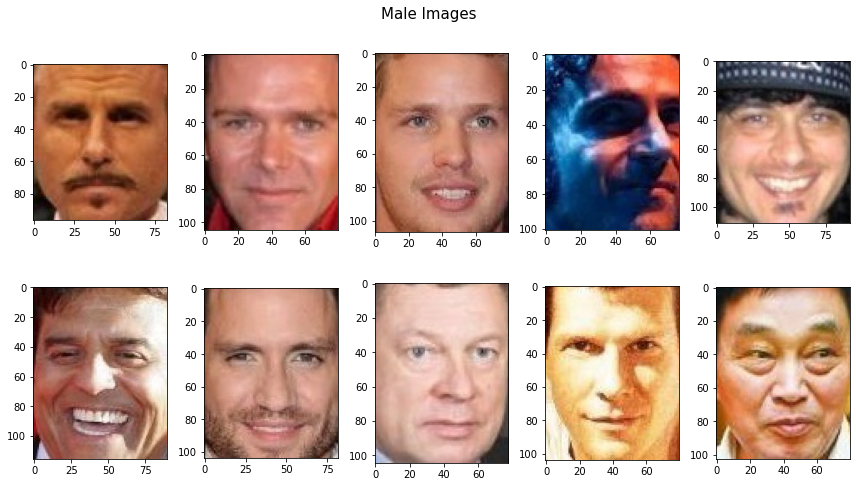

In [6]:
show_image('Images/Training/male')

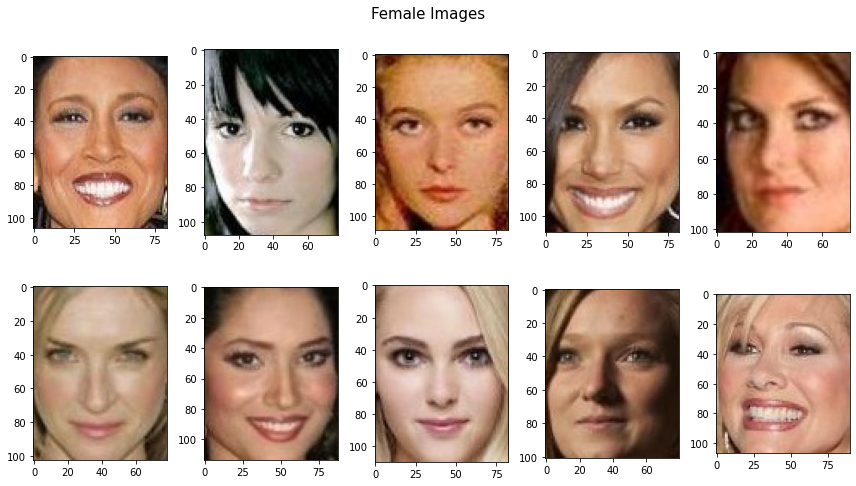

In [7]:
show_image('Images/Training/female')

In [8]:
ht = 150
wd = 150
train_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                    rotation_range=45,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    validation_split=0.2,
                                    horizontal_flip=True)

train_data = train_datagen.flow_from_directory(directory = traindir,
                                               target_size=(ht,wd),
                                               class_mode = "categorical",
                                               batch_size=32,
                                               subset="training")

val_datagen = ImageDataGenerator(rescale = 1/255.0)

val_data = train_datagen.flow_from_directory(directory = traindir,
                                             target_size=(ht,wd),
                                             class_mode = "categorical",
                                             batch_size=32,
                                             subset="validation")

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [10]:
mobileNet=MobileNetV2(weights="imagenet",include_top=False,input_shape=(ht,wd,3))

In [11]:
for l in mobileNet.layers:
    l.trainable=False

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [13]:
model=Sequential()
model.add(mobileNet)
model.add(Dense(128,activation="softmax"))

model.add(Flatten())
model.add(Dense(2,activation="softmax"))

model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 5, 5, 128)         163968    
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6402      
Total params: 2,428,354
Trainable params: 170,370
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
checkpoint = ModelCheckpoint("GenderClassifier.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=1)

In [15]:
batch_size = 32
history = model.fit_generator(train_data,
                              steps_per_epoch = len(train_data)// batch_size,epochs=15,
                              validation_data = val_data,
                              validation_steps = len(val_data)//batch_size,
                              callbacks = [checkpoint,earlystop],verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
36/36 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6380
Epoch 00001: val_accuracy improved from -inf to 0.79514, saving model to GenderClassifier.h5
36/36 [==============================] - 15s 417ms/step - loss: 0.6402 - accuracy: 0.6380 - val_loss: 0.5495 - val_accuracy: 0.7951
Epoch 2/15
36/36 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.7908
Epoch 00002: val_accuracy improved from 0.79514 to 0.82639, saving model to GenderClassifier.h5
36/36 [==============================] - 14s 377ms/step - loss: 0.4827 - accuracy: 0.7908 - val_loss: 0.4146 - val_accuracy: 0.8264
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8134
Epoch 00003: val_accuracy improved from 0.82639 to 0.87847, saving model to GenderClassifier.h5
36/36 [==============================] - 14s 376ms/step - loss: 0.4361 - accuracy: 0.8134 - v

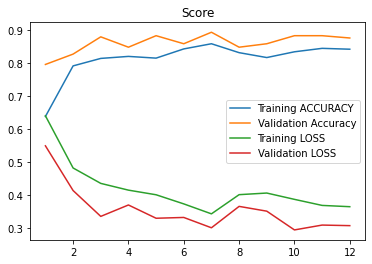

In [22]:
ACC=history.history['accuracy']
LOSS=history.history['loss']
val_ACC=history.history['val_accuracy']
val_LOSS=history.history['val_loss']
epochs=range(1,len(ACC)+1)


plt.title("Score")
plt.plot(epochs,ACC,label='Training ACCURACY')
plt.plot(epochs,val_ACC,label='Validation Accuracy')
plt.legend()

plt.plot(epochs,LOSS,label='Training LOSS')
plt.plot(epochs,val_LOSS,label='Validation LOSS')
plt.legend()



### TEST

In [24]:
from tensorflow.keras.preprocessing import image

In [ ]:

    img='Images/Validation/male/063880.jpg'

In [40]:
label={0:"Female",1:"Male"}
img1='cr7.jpg'


In [41]:
import cv2

In [52]:
def classifyImg(img):
    label = {0:"female",1:"male"} 
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    face=image
    face = cv2.resize(face,(150,150))
    img_scaled = face/255.0
    reshape = np.reshape(img_scaled,(1,150,150,3))
    img = np.vstack([reshape])
    result = model.predict_classes(img)
    
    
    if result == 0: 
        print("Prediction : FEMALE")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
        
    if result == 1:
        print("Prediction : MALE")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    
plt.show()


Prediction : MALE


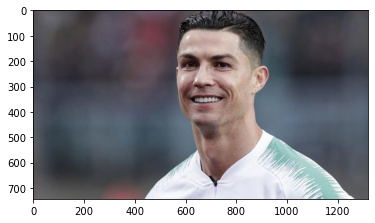

In [53]:
classifyImg('cr7.jpg')

Prediction : FEMALE


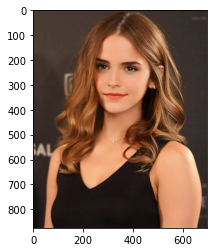

In [56]:
classifyImg('em.jpg')

Prediction : FEMALE


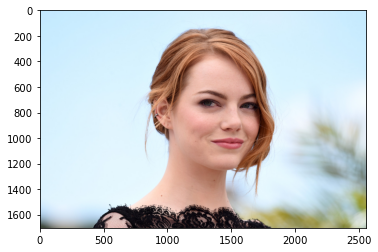

In [59]:
classifyImg('es.jfif')

In [57]:
import tensorflow as tf

model = tf.keras.models.load_model('GenderClassifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("GenderClassifier_TFL.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpncbtnqjz\assets


9553556